In [1]:
!pip install awswrangler

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
%%time
import awswrangler as wr
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
import sagemaker
from sagemaker import get_execution_role
import pandas as pd

CPU times: user 3.08 s, sys: 4.06 s, total: 7.14 s
Wall time: 801 ms


In [3]:
df_pred_test = wr.s3.read_csv('s3://ads508team7/jump_start/pred_test/data.csv')
df_pred_valid = wr.s3.read_csv('s3://ads508team7/jump_start/pred_valid/data.csv')

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def perform():
    cmtx = pd.DataFrame(
        confusion_matrix(df_pred_test['Target'], df_pred_test['PredBinary'], labels=[0,1]), 
        index=['true: {:}'.format(x) for x in [0,1]], 
        columns=['pred: {:}'.format(x) for x in [0,1]])  

    EvalTable = pd.DataFrame(columns = ['Accuracy','Sensitivity','Specificity','F1Measure'], index=['xgboost'])

    # Calculating Accuracy
    EvalTable.Accuracy = \
    (cmtx.iloc[0,0]+cmtx.iloc[1,1]) / sum(sum(cmtx.values))

    # Calculating Sensitivity    
    EvalTable.Sensitivity = cmtx.iloc[0,0]/(cmtx.iloc[0,0]+cmtx.iloc[0,1])

    # Calculating Specificity   
    EvalTable.Specificity = cmtx.iloc[1,1]/(cmtx.iloc[1,0]+cmtx.iloc[1,1])     

    # Calculating F1 Measure   
    EvalTable.F1Measure = \
      2 * ((EvalTable.Specificity * EvalTable.Sensitivity) / 
           (EvalTable.Specificity + EvalTable.Sensitivity)) 

    return EvalTable

best_cut_off_point = {}   
for cut_off_point in range(40, 70, 1):
    print('when cut off point is:', cut_off_point/100)
    df_pred_test['PredBinary'] = [1 if float(value) >= (cut_off_point/100) else 0 for value in df_pred_test['Pred'].values]
    print('\n')
    EvalTable = perform()
    print(EvalTable.F1Measure.values[0])
    best_cut_off_point[cut_off_point/100] = EvalTable.F1Measure.values[0]

when cut off point is: 0.4


0.42516949242494784
when cut off point is: 0.41


0.4375936961404366
when cut off point is: 0.42


0.43967147828606323
when cut off point is: 0.43


0.4403057118725547
when cut off point is: 0.44


0.44214007965831276
when cut off point is: 0.45


0.4484361792141031
when cut off point is: 0.46


0.4567737115815539
when cut off point is: 0.47


0.47187273203425295
when cut off point is: 0.48


0.4856569517549686
when cut off point is: 0.49


0.5023338106566926
when cut off point is: 0.5


0.5241368529952652
when cut off point is: 0.51


0.5467142875189116
when cut off point is: 0.52


0.5661708960378542
when cut off point is: 0.53


0.5876560013119904
when cut off point is: 0.54


0.6016984361597285
when cut off point is: 0.55


0.6068591008197771
when cut off point is: 0.56


0.6008577098899062
when cut off point is: 0.57


0.5708915324437371
when cut off point is: 0.58


0.5131152182950875
when cut off point is: 0.59


0.45767769971762595
when cut off poin

In [5]:
cut_off_df = pd.DataFrame.from_dict(best_cut_off_point, orient='index',columns = ['f1_measure'])
best_val = cut_off_df.sort_values(by='f1_measure', ascending=False)
best_val.head()

,f1_measure
0.55,0.606859
0.54,0.601698
0.56,0.600858
0.53,0.587656
0.57,0.570892


In [6]:
best = best_val.index[0]
df_pred_test['PredBinary'] = [1 if float(value) >= best else 0 for value in df_pred_test['Pred'].values]
df_pred_valid['PredBinary'] = [1 if float(value) >= best else 0 for value in df_pred_valid['Pred'].values]
EvalTable = perform()
print(EvalTable)

         Accuracy  Sensitivity  Specificity  F1Measure
xgboost  0.608531     0.598333     0.615631   0.606859


In [ ]:
!pip install pandasql

In [50]:
from IPython import display
from pandasql import sqldf
import random


pysqldf = lambda q: sqldf(q, globals())

df_comparison = pd.DataFrame()

at_least_record_to_have = 10

users = set(df_pred_valid['user_id'].unique())
users_rand = random.sample(users, 1000)


for index, user in enumerate(users_rand):
    records = df_pred_valid.query('user_id == @user')
    if len(records) >= at_least_record_to_have:
        
        sample_count = int(at_least_record_to_have / 2)
        
        by_chance = records.sample(5).Target.tolist()
        
        using_model = pysqldf("SELECT Target FROM records WHERE PredBinary = 1 ORDER BY Pred DESC LIMIT 5").Target.to_list()
        
        if not len(using_model) : continue
        
        by_chance_percentage = by_chance.count(1) / sample_count
        using_model_percentage = using_model.count(1) / len(using_model)

        last_row = len(df_comparison)
        
        df_comparison.loc[last_row,'user']       = user
        df_comparison.loc[last_row,'by_chance']  = by_chance_percentage
        df_comparison.loc[last_row,'with_model'] = using_model_percentage
        
        display.clear_output(wait=True)
        display.display(f"[{index / len(users):0.2%}]   {user} | {by_chance_percentage}, {using_model_percentage}")
        
df_comparison

'[0.50%]   50518 | 0.4, 0.0'

,user,by_chance,with_model
0,204058.0,0.6,0.8
1,165496.0,1.0,0.8
2,7677.0,0.6,0.6
3,155356.0,0.0,0.0
4,117654.0,0.4,0.4
...,...,...,...
493,102051.0,0.6,0.4
494,154011.0,1.0,1.0
495,63199.0,0.4,0.4
496,26451.0,0.4,0.6


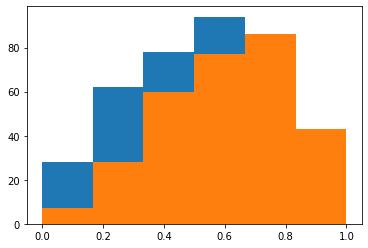

probability of getting 5 products to get re-ordered by those that have purchased more than 15 products:

By Chance: 45.04%
By Using the model: 62.31%


In [49]:
import matplotlib.pyplot as plt

plt.hist(df_comparison['by_chance'], range=(0,1), bins=6)
plt.hist(df_comparison['with_model'], range=(0,1), bins=6)


plt.show()

by_chance_mean = df_comparison['by_chance'].mean()
with_model_mean = df_comparison['with_model'].mean()


print('probability of getting 5 products to get re-ordered by those that have purchased more than 15 products:\n')
print(f'By Chance: {by_chance_mean:0.2%}')
print(f'By Using the model: {with_model_mean:0.2%}')